In [39]:
# Import packages
import os
import numpy as np
import pandas as pd
from scipy.stats import tvar, skew, kurtosis, zscore
from scipy.integrate import simps
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from utils.dataloaders import OneSignal
from utils import random_state
# import random

import matplotlib.pyplot as plt
import seaborn as sns

random_state(36)

In [67]:
class ML_experiment:
    def __init__(self, stratify=True, mode='binary', reporting=True, threshold=0.80):
        # Load the csv file containing the features
        current_directory = os.path.dirname(os.path.abspath('__file__'))
        folder_name = 'dataset/ML_features/'
        folder_path = os.path.join(current_directory, folder_name)
        # Construct features dataframe
        self.df = self.merge_csv_files(folder_path)

        # Set arguments
        self.stratify = stratify
        self.mode = mode
        self.reporting = reporting
        self.threshold = threshold

    #---------------------------------------------------
    #               Get features dataframe
    #---------------------------------------------------
    def merge_csv_files(self, folder_path):
        # Get a list of all CSV files in the specified folder
        csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

        # Initialize an empty list to store individual DataFrames
        dfs = []

        # Loop through each CSV file and append its DataFrame to the list
        for csv_file in csv_files:
            file_path = os.path.join(folder_path, csv_file)
            df = pd.read_csv(file_path)
            dfs.append(df)

        # Concatenate all DataFrames in the list into a single DataFrame
        merged_df = pd.concat(dfs, ignore_index=True)

        return merged_df
    
    #---------------------------------------------------
    #           Construct train/val/test split
    #---------------------------------------------------
    def data_split(self):
        # Construct patient numbers
        patient_numbers = [i for i in range(1, 122) if i not in [107, 120]+list(range(63, 79))]
        # Set random state: reproducibility
        random_state(36)

        # Split the data into training (70%), validation (15%) and test (15%) sets
        train_numbers, non_train_numbers = train_test_split(patient_numbers, test_size=0.3, random_state=36)
        val_numbers, test_numbers = train_test_split(non_train_numbers, test_size=0.5, random_state=36)

        # Print the lengths of the sets
        print(f"Training set size:\t{len(train_numbers)}")
        print(train_numbers)
        print(f"Validation set size:\t{len(val_numbers)}")
        print(val_numbers)
        print(f"Test set size:\t\t{len(test_numbers)}")
        print(test_numbers)

        # Select rows where the 'name' column is in the predetermined list
        self.train_data = self.df[self.df['name'].isin(train_numbers)]
        self.val_data = self.df[self.df['name'].isin(val_numbers)]
        self.test_data = self.df[self.df['name'].isin(test_numbers)]

    #---------------------------------------------------
    #               Outlier removal
    #---------------------------------------------------
    def outlier_removal(self):
        # Read in as copy
        train_features = self.train_data.copy()
        validation_features = self.val_data.copy()
        test_features = self.test_data.copy()

        # Drop "useless" features
        train_features = train_features.drop(columns=['peaks', 'name'])
        validation_features = validation_features.drop(columns=['peaks', 'name'])
        self.test_features = test_features.drop(columns=['peaks', 'name'])

        # Select labels
        self.train_labels = train_features['labels']
        self.validation_labels = validation_features['labels']
        # test_labels = test_features['labels']

        # Identify numeric columns
        numeric_columns = train_features.select_dtypes(include=np.number).columns

        # Separate non-numeric columns (e.g., 'labels')
        non_numeric_columns = ['labels']

        # Store non-numeric data
        train_non_numeric = train_features[non_numeric_columns]
        validation_non_numeric = validation_features[non_numeric_columns]
        # test_non_numeric = test_features[non_numeric_columns]

        # Drop non-numeric columns for scaling
        train_features = train_features.drop(columns=non_numeric_columns)
        validation_features = validation_features.drop(columns=non_numeric_columns)
        # test_features = test_features.drop(columns=non_numeric_columns)

        feature_list = train_features.columns
        print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

        # apply zscore only to numeric columns
        scaler = StandardScaler().fit(train_features[numeric_columns])
        zscore_features = scaler.transform(train_features[numeric_columns])

        # select all those values with zscore > -+ 3 as outliers
        abs_zscores_train = np.abs(zscore_features)

        outliers_detected = abs_zscores_train > 3
        print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

        # set outliers as missing values
        train_features[outliers_detected] = np.nan

        # Concatenate scaled numeric features with non-numeric columns
        self.train_features = pd.concat([train_non_numeric, train_features], axis=1)

        print('Missing values after outlier removal (train): ' + str(train_features.isnull().sum().sum()))

        # Apply to validation set
        zscore_features = scaler.transform(validation_features[numeric_columns])
        abs_zscores = np.abs(zscore_features)
        outliers_detected = abs_zscores > 3
        print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))

        validation_features[outliers_detected] = np.nan

        self.validation_features = pd.concat([validation_non_numeric, validation_features], axis=1)

        print('Missing values after outlier removal (validation): ' + str(validation_features.isnull().sum().sum()))

        if self.reporting:
            self.plot_outliersAnalysis(abs_zscores_train, feature_list)

    def drop_nan_values(self, drop_nan=True):
        if drop_nan == True:
            self.train_features = self.train_features.dropna()
            self.validation_features = self.validation_features.dropna()
            # test_features = test_features.dropna()

    #---------------------------------------------------
    #               Subsampling
    #---------------------------------------------------
    def subsampling(self):
        # Parameters
        # random_seed = 36

        # Construct df
        train_df = self.train_features.copy()
        # display(train_df)
        val_df = self.validation_features.copy()
        test_df = self.test_features.copy()

        print('Distribution before subsampling:')
        data = {}
        for split_name, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):

            # Subsampling
            df_N = df[df['labels'] == 'N']  #0
            df_V = df[df['labels'] == 'V']  #1
            df_S = df[df['labels'] == 'S']  #2
                    
            n_smallest_class = min(len(df_N), len(df_V), len(df_S))
            print(len(df_N), len(df_V), len(df_S))

            if split_name in ["train", "val"]:
                if self.stratify:
                    # Use the sample method to get a random subset
                    if self.mode == 'binary':
                        df_N = df_N.sample(n=2*n_smallest_class, random_state=36)
                    else:
                        df_N = df_N.sample(n=n_smallest_class, random_state=36)
                        
                    df_V = df_V.sample(n=n_smallest_class, random_state=36)
                    df_S = df_S.sample(n=n_smallest_class, random_state=36)

            # Now put them all back together       
            df = pd.concat([df_N, df_V, df_S], axis=0, ignore_index=True)
            
            # Shuffle the dataframe
            df = df.sample(frac=1).reset_index(drop=True)

            # Assign the modified DataFrame back to the original variable
            data[split_name] = df

        self.train_features = data['train']
        self.validation_features = data['val']
        self.test_features = data['test']

        print(('\nDistribution after subsampling:'))
        print(self.train_features['labels'].value_counts())
        print(self.validation_features['labels'].value_counts())
        print(self.test_features['labels'].value_counts())

    #---------------------------------------------------
    #               Data standardization
    #---------------------------------------------------
    def standardize_data(self):

        # Standarize data with z-score transformation
        # Select labels
        self.train_labels = self.train_features['labels']
        self.validation_labels = self.validation_features['labels']
        self.test_labels = self.test_features['labels']

        # Drop "useless" features
        train_features_zscore = self.train_features.copy().drop(columns=['labels'])
        validation_features_zscore = self.validation_features.copy().drop(columns=['labels'])
        test_features_zscore = self.test_features.copy().drop(columns=['labels'])

        feature_list = train_features_zscore.columns

        self.transformer = StandardScaler().fit(train_features_zscore)
        train_features_zscore = self.transformer.transform(train_features_zscore)
        self.train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

        # adapt validation set
        validation_features_zscore = self.transformer.transform(validation_features_zscore)
        self.validation_features_zscore = pd.DataFrame(data=validation_features_zscore, columns=feature_list)
        # adapt test set
        test_features_zscore = self.transformer.transform(test_features_zscore)
        self.test_features_zscore = pd.DataFrame(data=test_features_zscore, columns=feature_list)

        # display(train_features_zscore)

    #---------------------------------------------------
    #           Remove uncorrelated features
    #---------------------------------------------------
    def remove_uncorrelated_features(self):
        # 2. Eliminate correlated features
        # a. visualize correlation matrix
        cor_matrix = self.train_features_zscore.corr().abs()
        if self.reporting:
            self.plot_correlationMatrix(cor_matrix, self.train_features_zscore.columns)

        # b. drop correlated features
        correlated_features = set()
        correlation_matrix = self.train_features_zscore.corr()
        median_corr = (correlation_matrix.abs()).median(axis=0)

        for i in range(len(correlation_matrix .columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > self.threshold: # value to filter correlation on
                    if median_corr[i] < median_corr[j]:
                        colname = correlation_matrix.columns[i]
                    else:
                        colname = correlation_matrix.columns[j]
                    correlated_features.add(colname)

        # Drop correlated features
        self.train_features_zscore.drop(labels=correlated_features, axis=1, inplace=True)
        self.validation_features_zscore.drop(labels=correlated_features, axis=1, inplace=True)
        self.test_features_zscore.drop(labels=correlated_features, axis=1, inplace=True)

        # see how it drops correlated / drop the one that had a lower correlation w.r to the other feat
        print('Deleted features: ' + str(correlated_features))

        # c. plot correlation matrix with remaining features
        cor_matrix = self.train_features_zscore.corr().abs()
        feature_list = list(self.train_features_zscore.columns)
        if self.reporting:
            f2 = self.plot_correlationMatrix(cor_matrix, feature_list)

        # adapt test set: pick only selected features
        # validation_features = validation_features[feature_list]

    #---------------------------------------------------
    #           Conversion to binary
    #---------------------------------------------------
    def to_binary(self, labels):
        out = labels.replace(['V', 'S'], 'A')

        if self.gradientboost == True:
            out = out.replace('N', 0)
            out = out.replace('A', 1)

        return out
        
    #---------------------------------------------------
    #               Fit & test models
    #---------------------------------------------------
    def set_model(self, clf):
        self.clf = clf

    def fit_model(self):
        train_features = self.train_features_zscore
        train_labels = self.train_labels
        if self.mode == 'binary':
            train_labels = self.to_binary(train_labels)

        self.clf.fit(train_features, train_labels)

        return self.clf

    def test_model_performance(self, data='test'):
        if data == 'test':
            test_features = self.test_features_zscore
            test_labels = self.test_labels
        elif data == 'val':
            test_features = self.validation_features_zscore
            test_labels = self.validation_labels
        else:
            print("Not able to use other dataset then test ('test') or validation ('val') dataset.")

        if self.mode == 'binary':
            # Construct binary labels
            test_labels = self.to_binary(test_labels)

        model = self.clf
        # Predit test labels
        test_predicted = model.predict(test_features)

        # plot confusion matrix
        if self.reporting:
            self.plot_confusionMatrix(test_labels, test_predicted, model)

        # display classification results
        if self.gradientboost == True:
            # Assuming model.classes_ contains integer class labels
            class_names = list(map(str, model.classes_))
        else:
            class_names = model.classes_

        if self.reporting:
            print(classification_report(test_labels, test_predicted, target_names=class_names, digits=3))

        return model, test_predicted
    
    #---------------------------------------------------
    #               Main function
    #---------------------------------------------------
    def main(self, clf, gradientboost=False):
        self.gradientboost = gradientboost
        self.data_split()
        self.outlier_removal()
        self.drop_nan_values()
        self.subsampling()
        self.standardize_data()
        self.remove_uncorrelated_features()
        self.set_model(clf)
        model = self.fit_model()
        _, val_predicted = self.test_model_performance(data='val')
        _, test_predicted = self.test_model_performance(data='test')

        return model, val_predicted, test_predicted
    
    def return_features(self, gradientboost=False):
        self.gradientboost = gradientboost
        self.data_split()
        self.outlier_removal()
        self.drop_nan_values()
        self.subsampling()
        self.standardize_data()
        self.remove_uncorrelated_features()

        train_features, train_labels = self.train_features_zscore, self.train_labels
        validation_features, validation_features_labels = self.validation_features_zscore, self.validation_labels
        test_features, test_labels = self.test_features_zscore, self.test_labels
        
        # self.set_model(clf)
        # model = self.fit_model()
        # _, val_predicted = self.test_model_performance(data='val')
        # _, test_predicted = self.test_model_performance(data='test')
        return train_features, train_labels, validation_features, validation_features_labels, test_features, test_labels
    
    #---------------------------------------------------
    #           Get prediction probabilities
    #---------------------------------------------------
    def get_prob(self, data='test'):
        if data == 'test':
            test_features = self.test_features_zscore
            test_labels = self.test_labels
        elif data == 'val':
            test_features = self.validation_features_zscore
            test_labels = self.validation_labels
        else:
            print("Not able to use other dataset then test ('test') or validation ('val') dataset.")

        if self.mode == 'binary':
            # Construct binary labels
            test_labels = self.to_binary(test_labels)

        test_prediction_prob = self.clf.predict_proba(test_features)

        return test_prediction_prob
    

    # # print(test_prediction_prob)

    # idx_N = np.where(test_labels == 'N')[0]
    # idx_A = np.where((test_labels == 'V')+(test_labels == 'S'))[0]

    # # Histogram predictions without error bars:
    # fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # axs[0].set_title('Confidence of Normal peaks predictions')
    # axs[0].hist(test_prediction_prob[idx_N, 1], histtype='step')

    # axs[1].set_title('Confidence of Abnormal peaks predictions')
    # axs[1].hist(test_prediction_prob[idx_A, 0], histtype='step')

    # for ax in axs:
    #     ax.set_xlabel('Confidence of prediction')
    #     ax.set_ylabel('Number of predictions')
    #     # ax.legend()

    # plt.show()   

    #---------------------------------------------------
    #           Supporting function: plots etc.
    #---------------------------------------------------
    def plot_correlationMatrix(self, correlation_matrix, features):
        f = plt.figure(figsize=(10, 8))
        plt.matshow(correlation_matrix, fignum=f.number)
        # plt.xticks(range(len(features)), features, fontsize=10, rotation=90)

        plt.subplots_adjust(bottom=0.2)

        # plt.xticks(range(len(features)), features, fontsize=10, rotation=60, ha='right')
        plt.xticks([])
        ax = f.get_axes()[0]
        print(ax)
        secax = ax.secondary_xaxis('bottom')
        secax.set_xticks(range(len(features)), features, fontsize=10, rotation=90)
        plt.yticks(range(len(features)), features, fontsize=10)
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=14)
        # plt.title('Feature correlation matrix', fontsize=20)
        #plt.title('Correlation Matrix', fontsize=16)
        # plt.tight_layout()
        return

    def plot_outliersAnalysis(self, abs_zscores, feature_list):
        # # number of outliers per subject
        # bool_zscores = (abs_zscores > 3).sum(axis=1)
        # bool_zscores.hist()
        # plt.title("Number of outliers per subject")
        # plt.show()

        # number of outliers per feature
        bool_zscores = (abs_zscores > 3).sum(axis=0)
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

        ax.bar(feature_list,bool_zscores)
        plt.title("Number of outliers per feature")
        plt.xticks(np.arange(len(feature_list)), feature_list, rotation=90)
        plt.show()
        return

    def plot_confusionMatrix(self, test_labels, test_predicted, clf):
        cm = confusion_matrix(test_labels, test_predicted, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                        display_labels=clf.classes_)
        disp.plot()
        plt.show()
        return

In [68]:
clf = RandomForestClassifier(criterion='gini',
                             n_estimators=80,
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='sqrt',

                             min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=None,
                             random_state=36,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0.0,
                             max_samples=None)

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


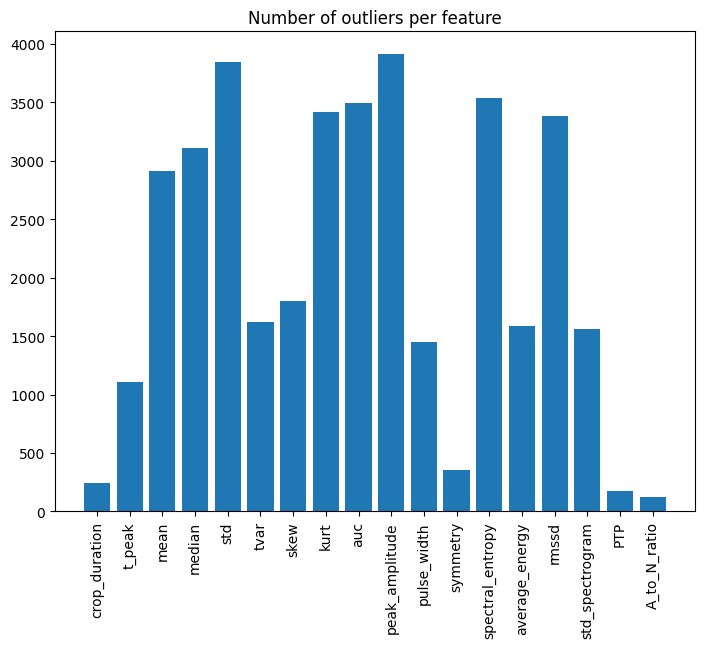

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
S    4041
V    4041
N    4041
Name: count, dtype: int64
labels
V    543
N    543
S    543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Axes(0.15,0.09;0.775x0.775)
Deleted features: {'peak_amplitude', 'std_spectrogram', 'average_energy', 'mean', 'tvar', 'rmssd', 'std'}
Axes(0.15,0.09;0.775x0.775)


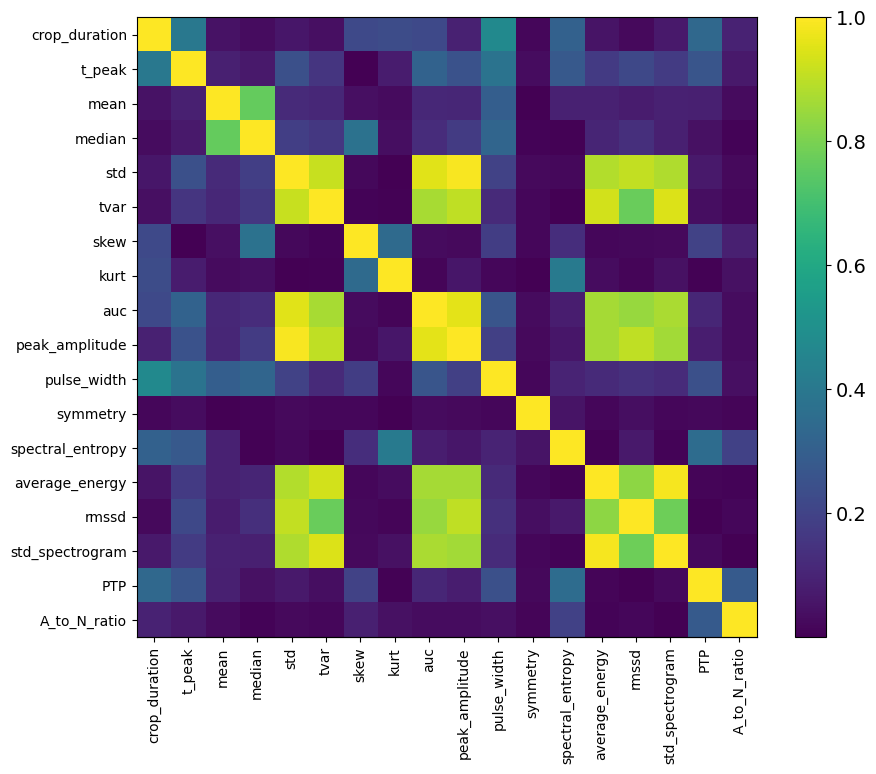

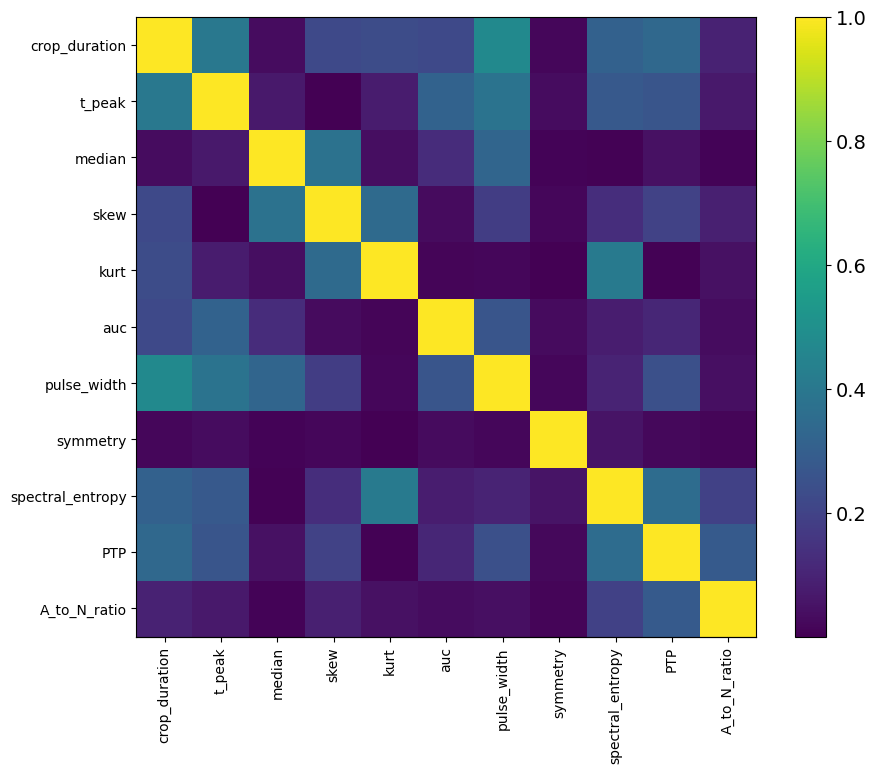

In [69]:
exp = ML_experiment(reporting=True, threshold=0.75, mode='multiclass')
train_features, train_labels, validation_features, validation_labels, test_features, test_labels = exp.return_features()

In [17]:
# # Save DataFrames to .csv file
# current_directory = os.path.dirname(os.path.abspath('__file__'))
# folder_name = 'dataset/ML_split/multiclass'
# target_folder = os.path.join(current_directory, folder_name)

# ## Check if the folder exists and create it if not
# if not os.path.exists(target_folder):
#     os.makedirs(target_folder)

# for name, data in zip(['train_features', 'train_labels', 'validaion_features', 'validation_labels', 'test_features', 'test_labels'],
#                       [train_features, train_labels, validation_features, validation_labels, test_features, test_labels]):

#     file_path = os.path.join(target_folder, name+'.csv')
#     data.to_csv(file_path, index=False)

In [96]:
# test_labels

0        N
1        N
2        N
3        N
4        N
        ..
38695    N
38696    N
38697    N
38698    N
38699    N
Name: labels, Length: 38700, dtype: object

In [104]:
# train_features

In [76]:
param_grid = {
    'criterion': ['gini'],
    'n_estimators': [40, 80, 120],
    'max_depth': [None],            # [None, 10, 20]
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],

    # Single options
    'min_weight_fraction_leaf': [0.0],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'bootstrap': [True],
    'oob_score': [False],
    'n_jobs': [None],
    'random_state': [36],
    'verbose': [0],
    'warm_start': [False],
    'class_weight': [None],
    'ccp_alpha': [0.0],
    'max_samples': [None]
}

# Best:
{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 40}

In [79]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=36), param_grid, cv=3, scoring='recall', verbose=3)
grid_search.fit(train_features, exp.to_binary(train_labels))

# Get the best parameters
best_params = grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=nan total time=   2.0s
[CV 2/3] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=nan total time=   1.8s
[CV 3/3] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=40;, score=nan total time=   1.8s
[CV 1/3] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=nan total time=   3.6s
[CV 2/3] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=nan total time=   3.6s
[CV 3/3] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=nan total time=   3.6s
[CV 1/3] END criterion=gin

In [80]:
best_params

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 40}

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


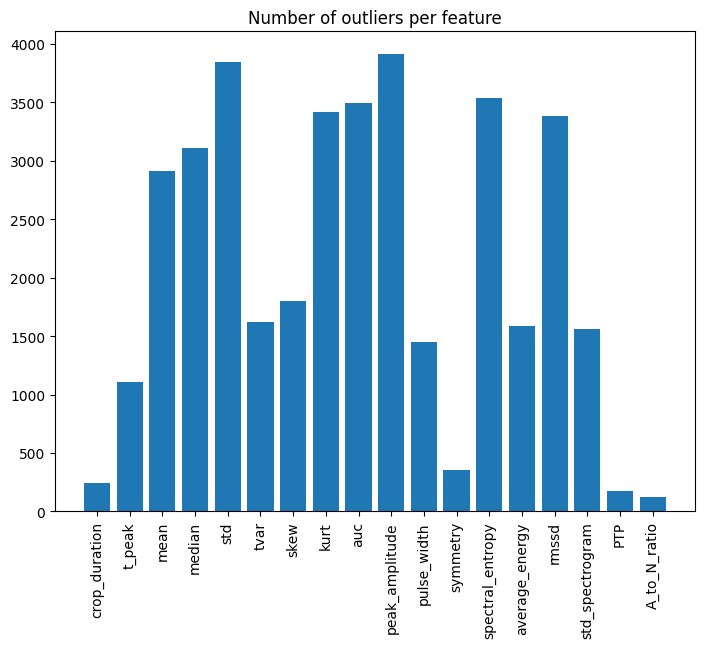

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
N    8082
S    4041
V    4041
Name: count, dtype: int64
labels
N    1086
V     543
S     543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Axes(0.15,0.09;0.775x0.775)
Deleted features: {'peak_amplitude', 'std_spectrogram', 'average_energy', 'mean', 'tvar', 'rmssd', 'std'}
Axes(0.15,0.09;0.775x0.775)


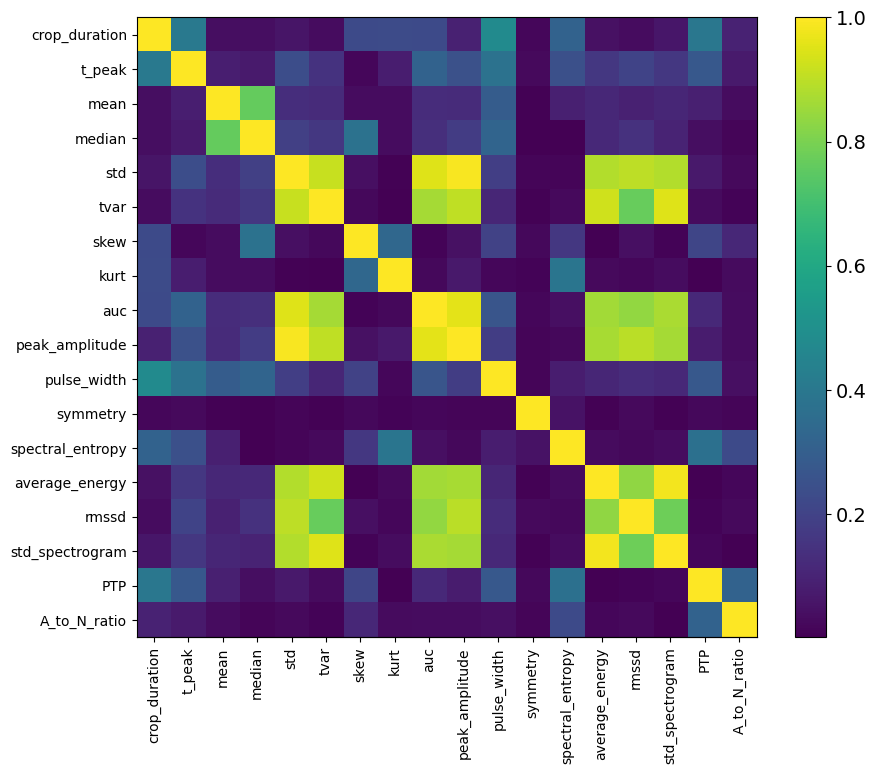

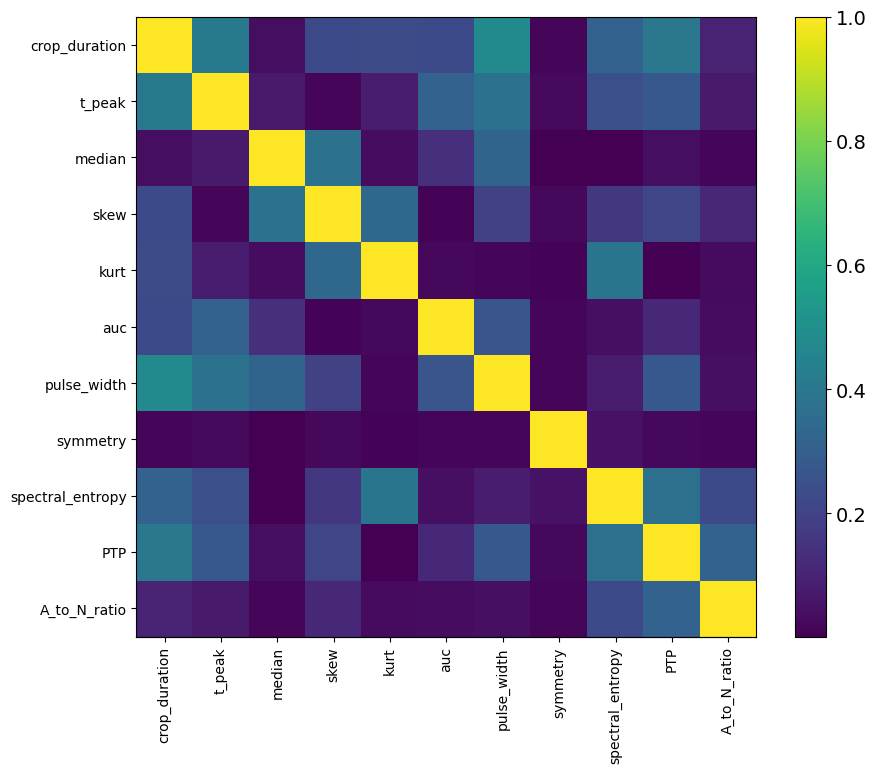

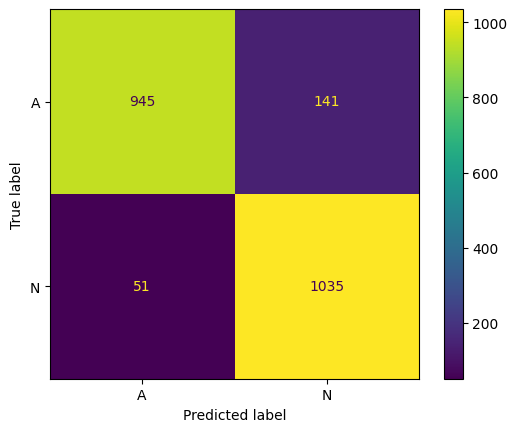

              precision    recall  f1-score   support

           A      0.949     0.870     0.908      1086
           N      0.880     0.953     0.915      1086

    accuracy                          0.912      2172
   macro avg      0.914     0.912     0.911      2172
weighted avg      0.914     0.912     0.911      2172



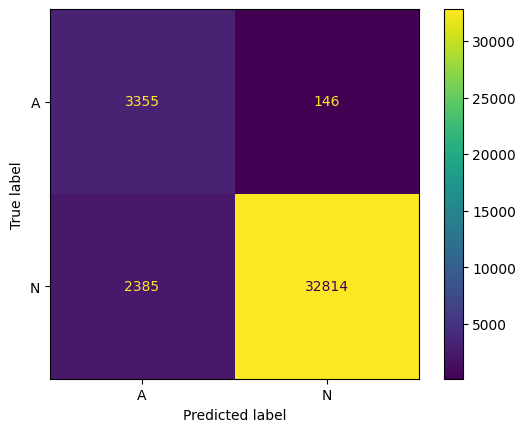

              precision    recall  f1-score   support

           A      0.584     0.958     0.726      3501
           N      0.996     0.932     0.963     35199

    accuracy                          0.935     38700
   macro avg      0.790     0.945     0.844     38700
weighted avg      0.958     0.935     0.941     38700



(RandomForestClassifier(n_estimators=50, random_state=36),
 array(['N', 'N', 'A', ..., 'N', 'N', 'N'], dtype=object),
 array(['N', 'A', 'N', ..., 'N', 'N', 'N'], dtype=object))

In [93]:
clf = RandomForestClassifier(criterion='gini',
                             n_estimators=50,
                             max_depth=None,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='sqrt',

                             min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=None,
                             random_state=36,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0.0,
                             max_samples=None)

exp = ML_experiment(threshold=0.75)
exp.main(clf)

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


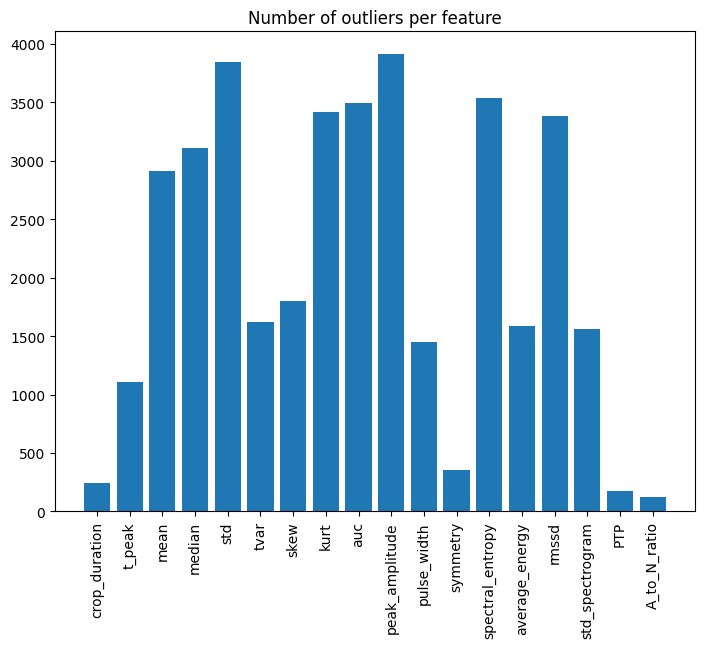

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
N    8082
S    4041
V    4041
Name: count, dtype: int64
labels
N    1086
V     543
S     543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Axes(0.15,0.09;0.775x0.775)
Deleted features: {'peak_amplitude', 'std_spectrogram', 'average_energy', 'mean', 'tvar', 'rmssd', 'std'}
Axes(0.15,0.09;0.775x0.775)


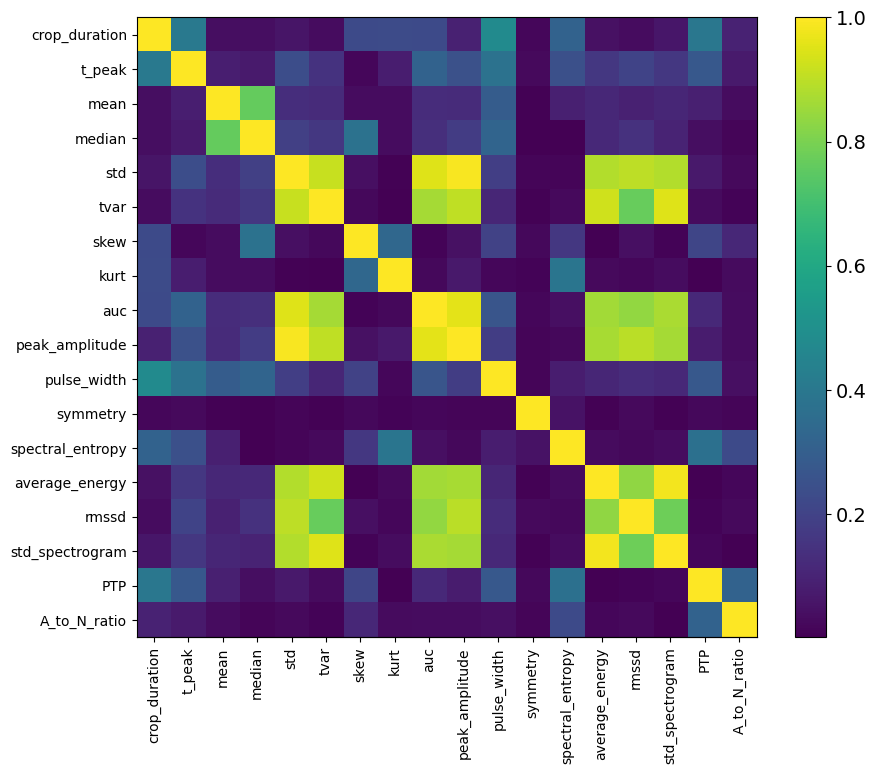

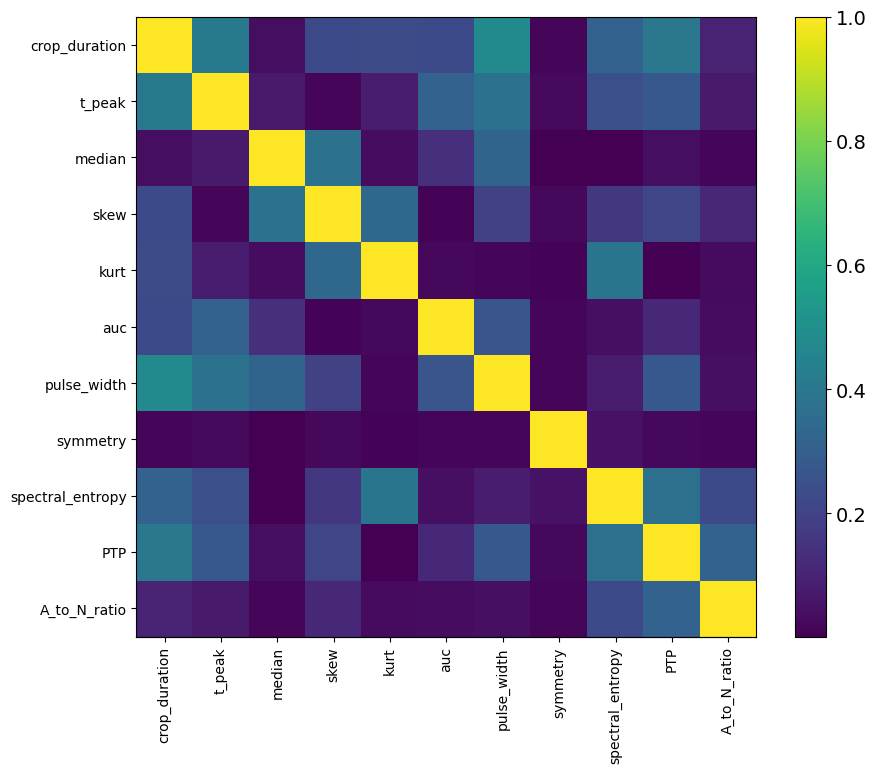

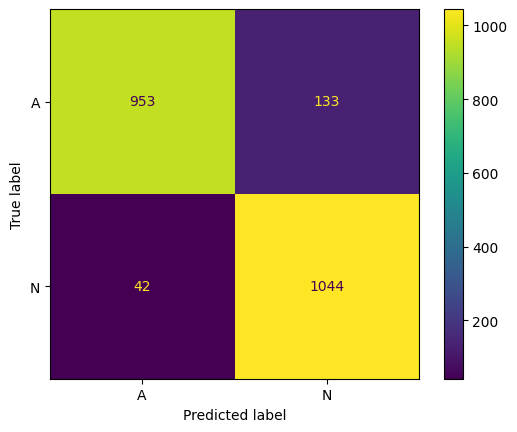

              precision    recall  f1-score   support

           A      0.958     0.878     0.916      1086
           N      0.887     0.961     0.923      1086

    accuracy                          0.919      2172
   macro avg      0.922     0.919     0.919      2172
weighted avg      0.922     0.919     0.919      2172



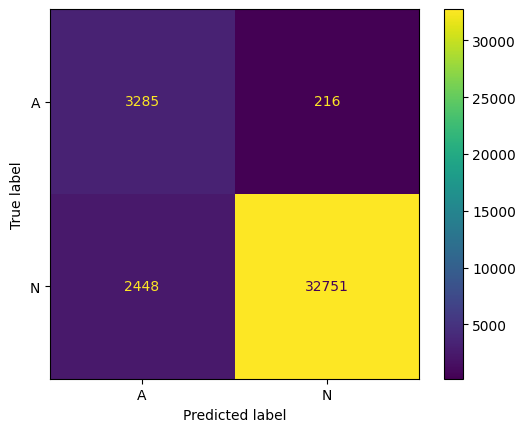

              precision    recall  f1-score   support

           A      0.573     0.938     0.712      3501
           N      0.993     0.930     0.961     35199

    accuracy                          0.931     38700
   macro avg      0.783     0.934     0.836     38700
weighted avg      0.955     0.931     0.938     38700



(LogisticRegression(random_state=36),
 array(['N', 'N', 'A', ..., 'N', 'N', 'N'], dtype=object),
 array(['N', 'A', 'N', ..., 'N', 'N', 'N'], dtype=object))

In [92]:
# clf = RandomForestClassifier(criterion='gini',
#                              n_estimators=50,
#                              max_depth=None,
#                              min_samples_split=2,
#                              min_samples_leaf=1,
#                              max_features='sqrt',

#                              min_weight_fraction_leaf=0.0,
#                              max_leaf_nodes=None,
#                              min_impurity_decrease=0.0,
#                              bootstrap=True,
#                              oob_score=False,
#                              n_jobs=None,
#                              random_state=36,
#                              verbose=0,
#                              warm_start=False,
#                              class_weight=None,
#                              ccp_alpha=0.0,
#                              max_samples=None)


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=36)

exp = ML_experiment(threshold=0.75)
exp.main(clf)

In [78]:
# import xgboost as xgb

# # Define the XGBoost model
# clf_xgb = xgb.XGBClassifier(
#     n_estimators=80,
#     max_depth=None,
#     learning_rate=0.1,
#     subsample=1.0,
#     colsample_bytree=1.0,
#     gamma=0,
#     reg_alpha=0,
#     reg_lambda=1,
#     min_child_weight=1,
#     # objective='multi:softmax',  # for multi-class classification
#     objective='binary:logistic',  # for multi-class classification

#     # num_class=len(set(y)),
#     class_labels=['A', 'N'],
#     random_state=36,
#     n_jobs=1  # Set the number of parallel threads for XGBoost
# )

# exp_xgb = ML_experiment()
# exp_xgb.main(clf_xgb, threshold=0.75, gradientboost=True)

In [79]:
# from sklearn.ensemble import RandomForestClassifier

# clf = RandomForestClassifier(n_estimators=80,
#                         criterion='gini',
#                         max_depth=None,
#                         min_samples_split=2,
#                         min_samples_leaf=1,
#                         min_weight_fraction_leaf=0.0,
#                         max_features='sqrt',
#                         max_leaf_nodes=None,
#                         min_impurity_decrease=0.0,
#                         bootstrap=True,
#                         oob_score=False,
#                         n_jobs=None,
#                         random_state=36,
#                         verbose=0,
#                         warm_start=False,
#                         class_weight=None,
#                         ccp_alpha=0.0,
#                         max_samples=None)

# exp = ML_experiment(threshold=0.75)
# exp.main(clf, threshold=0.75)


In [80]:
test_prediction_prob = exp.get_prob()
test_labels = exp.test_labels

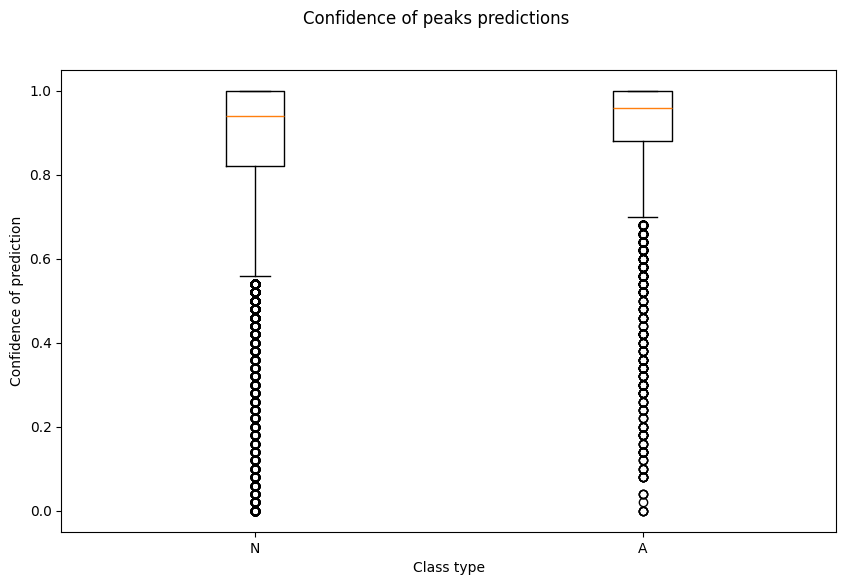

In [81]:
# print(test_prediction_prob)

idx_N = np.where(test_labels == 'N')[0]
idx_A = np.where((test_labels == 'V')+(test_labels == 'S'))[0]

# Histogram predictions without error bars:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fig.suptitle('Confidence of peaks predictions')

ax.boxplot([test_prediction_prob[idx_N, 1], test_prediction_prob[idx_A, 0]], labels=['N', 'A'])

# ax.set_title('Confidence of Abnormal peaks predictions')

ax.set_ylabel('Confidence of prediction')
ax.set_xlabel('Class type')
    # ax.legend()

plt.show()   

In [82]:
exp.clf.feature_importances_

array([0.06849936, 0.03770087, 0.04301131, 0.02882584, 0.03540031,
       0.05509962, 0.02393697, 0.05516888, 0.06836716, 0.37798408,
       0.20600561])

In [83]:
print(exp.clf.feature_names_in_)
print(exp.clf.feature_importances_)

# ['crop_duration' 't_peak' 'median' 'skew' 'kurt' 'auc' 'pulse_width'
#  'symmetry' 'spectral_entropy' 'PTP' 'A_to_N_ratio']
# [0.0874278  0.03967066 0.04343822 0.03547233 0.03640183 0.06034213
#  0.02886535 0.05575659 0.06504213 0.363285   0.18429795]

['crop_duration' 't_peak' 'median' 'skew' 'kurt' 'auc' 'pulse_width'
 'symmetry' 'spectral_entropy' 'PTP' 'A_to_N_ratio']
[0.06849936 0.03770087 0.04301131 0.02882584 0.03540031 0.05509962
 0.02393697 0.05516888 0.06836716 0.37798408 0.20600561]


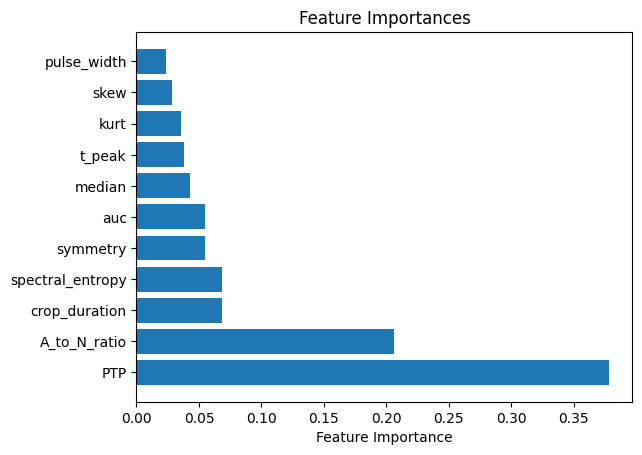

In [90]:
feature_names = exp.clf.feature_names_in_
importances = exp.clf.feature_importances_

# Sort the features based on their importances
sorted_indices = importances.argsort()[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_importances = importances[sorted_indices]

# Create a bar plot
plt.barh(range(len(sorted_feature_names)), sorted_importances, align="center")
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.title("Feature Importances")
plt.show()

In [60]:
from sklearn.svm import SVC
clf = SVC(C=1.0,
        kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
        degree=6,
        gamma='scale',
        coef0=0.0,
        shrinking=True,
        probability=False,
        tol=0.001,
        cache_size=200,
        class_weight=None,
        verbose=False,
        max_iter=- 1,
        decision_function_shape='ovr',
        break_ties=False)

In [65]:
exp = ML_experiment(threshold=0.75, reporting=True, mode='multiclass')

Training set size:	72
[54, 17, 96, 119, 103, 57, 24, 8, 89, 80, 39, 16, 121, 48, 106, 44, 11, 49, 117, 91, 98, 33, 9, 114, 90, 110, 104, 85, 5, 27, 52, 18, 58, 50, 86, 101, 21, 19, 20, 109, 42, 25, 84, 26, 47, 102, 112, 14, 22, 46, 118, 94, 15, 37, 105, 2, 32, 23, 115, 87, 81, 7, 56, 38, 10, 45, 108, 34, 41, 31, 116, 6]
Validation set size:	15
[36, 97, 60, 28, 40, 100, 3, 83, 111, 62, 12, 61, 59, 4, 55]
Test set size:		16
[53, 51, 79, 1, 29, 30, 93, 82, 35, 43, 92, 99, 95, 88, 113, 13]
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


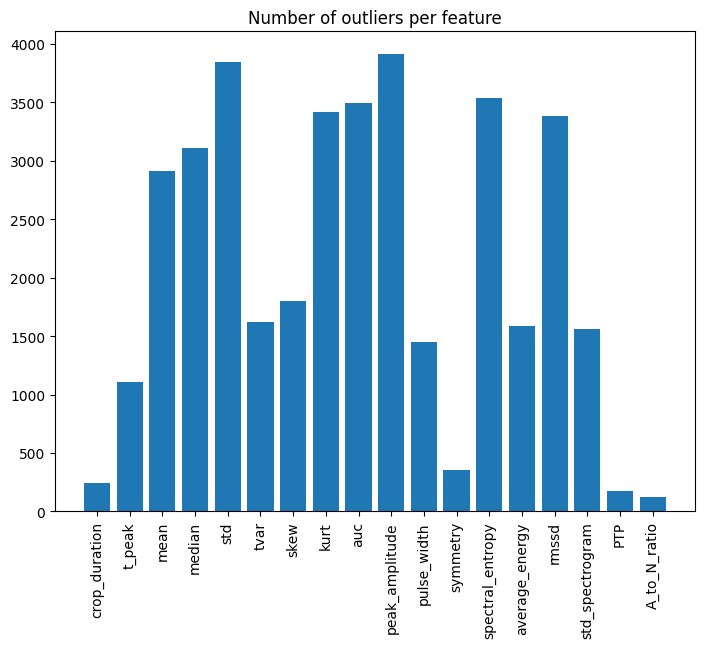

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
S    4041
V    4041
N    4041
Name: count, dtype: int64
labels
V    543
N    543
S    543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Axes(0.15,0.09;0.775x0.775)
Deleted features: {'peak_amplitude', 'std_spectrogram', 'average_energy', 'mean', 'tvar', 'rmssd', 'std'}
Axes(0.15,0.09;0.775x0.775)


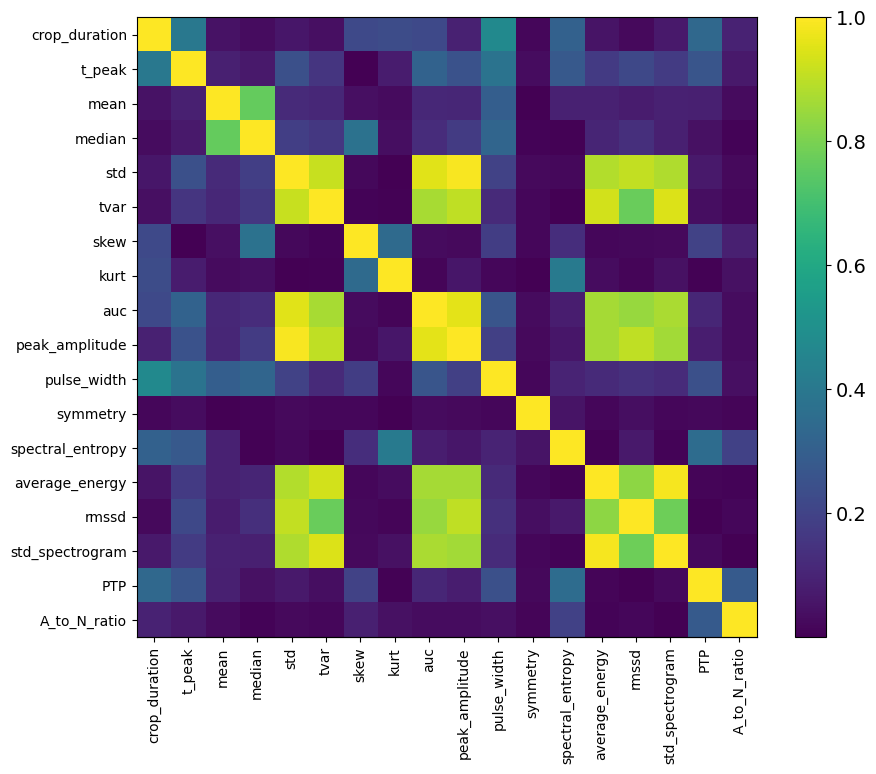

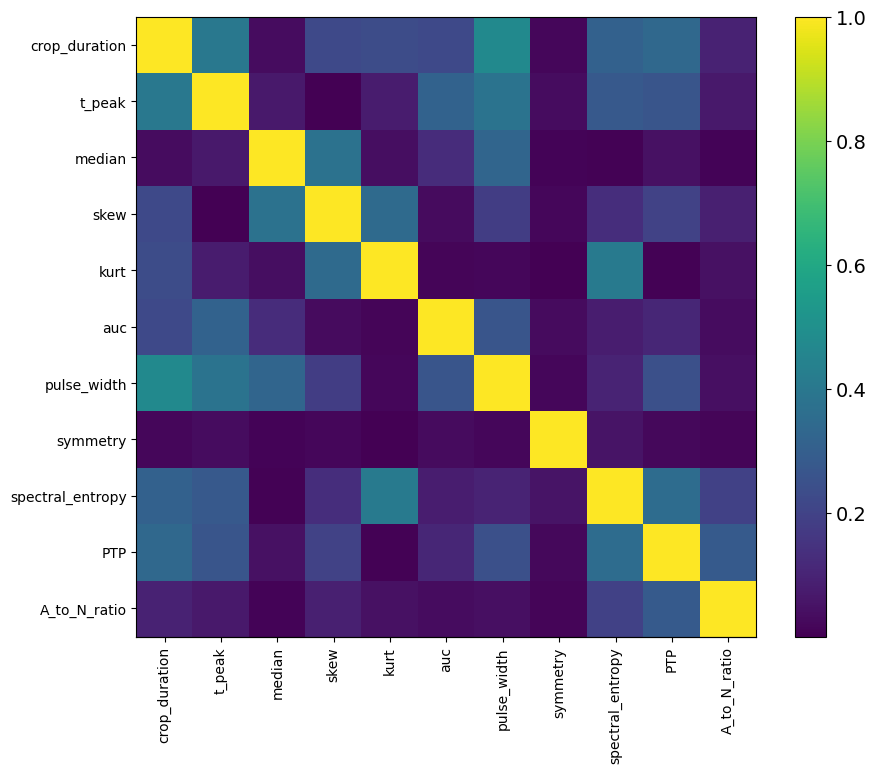

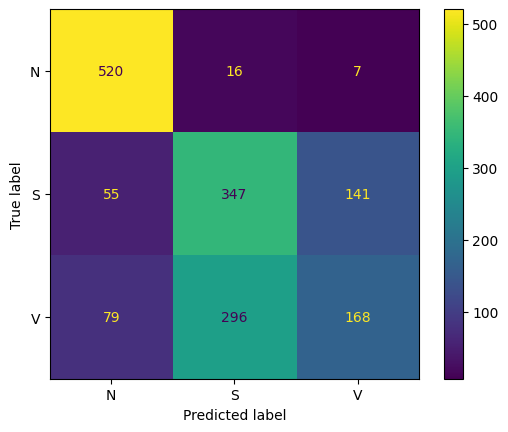

              precision    recall  f1-score   support

           N       0.80      0.96      0.87       543
           S       0.53      0.64      0.58       543
           V       0.53      0.31      0.39       543

    accuracy                           0.64      1629
   macro avg       0.62      0.64      0.61      1629
weighted avg       0.62      0.64      0.61      1629



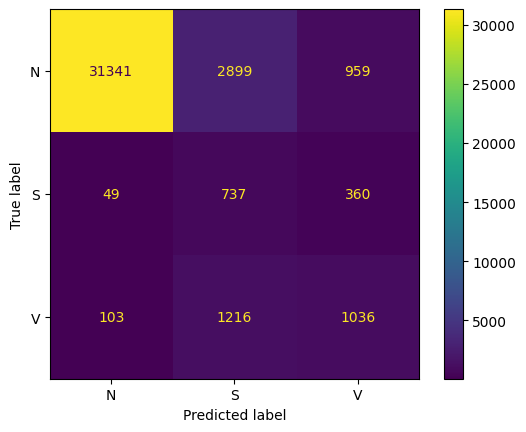

              precision    recall  f1-score   support

           N       1.00      0.89      0.94     35199
           S       0.15      0.64      0.25      1146
           V       0.44      0.44      0.44      2355

    accuracy                           0.86     38700
   macro avg       0.53      0.66      0.54     38700
weighted avg       0.94      0.86      0.89     38700



(SVC(degree=6),
 array(['S', 'S', 'N', ..., 'N', 'V', 'S'], dtype=object),
 array(['N', 'N', 'N', ..., 'N', 'S', 'S'], dtype=object))

In [66]:
exp.main(clf)

In [93]:
exp_2 = ML_experiment(mode='classes')

Training set size:	72
Validation set size:	15
Test set size:		16
Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618
Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026


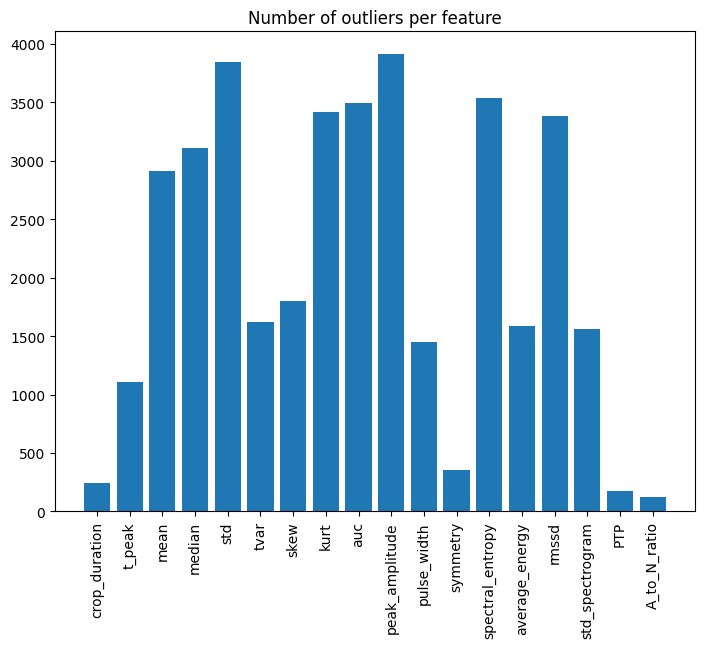

Distribution before subsampling:
148044 4041 5397
26276 711 543
35199 2355 1146

Distribution after subsampling:
labels
S    4041
V    4041
N    4041
Name: count, dtype: int64
labels
V    543
N    543
S    543
Name: count, dtype: int64
labels
N    35199
V     2355
S     1146
Name: count, dtype: int64
Deleted features: {'rmssd', 'average_energy', 'peak_amplitude', 'std', 'tvar', 'std_spectrogram'}


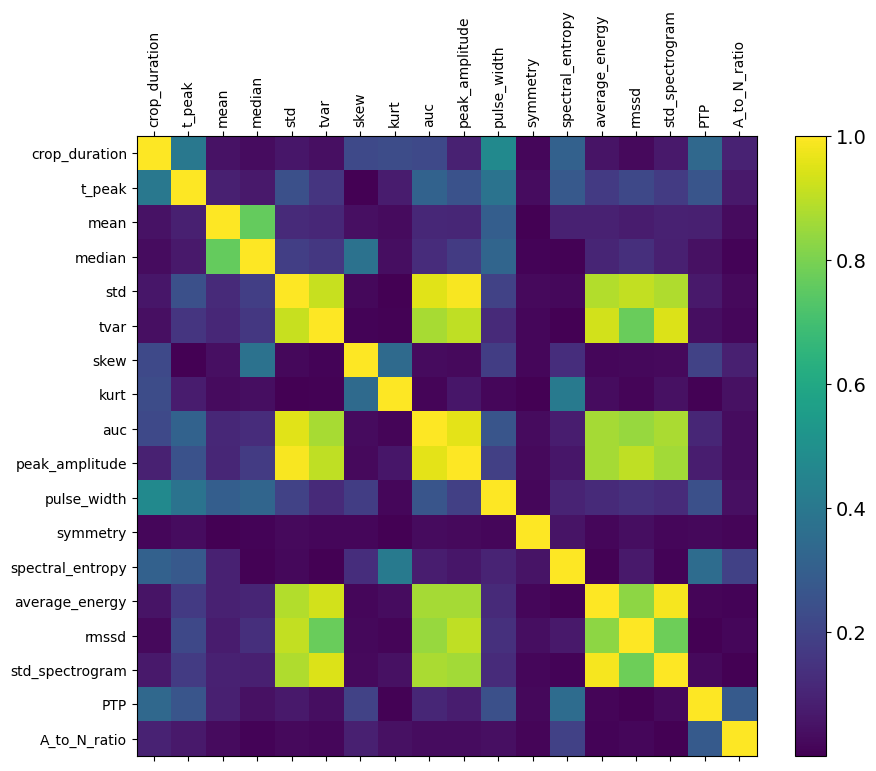

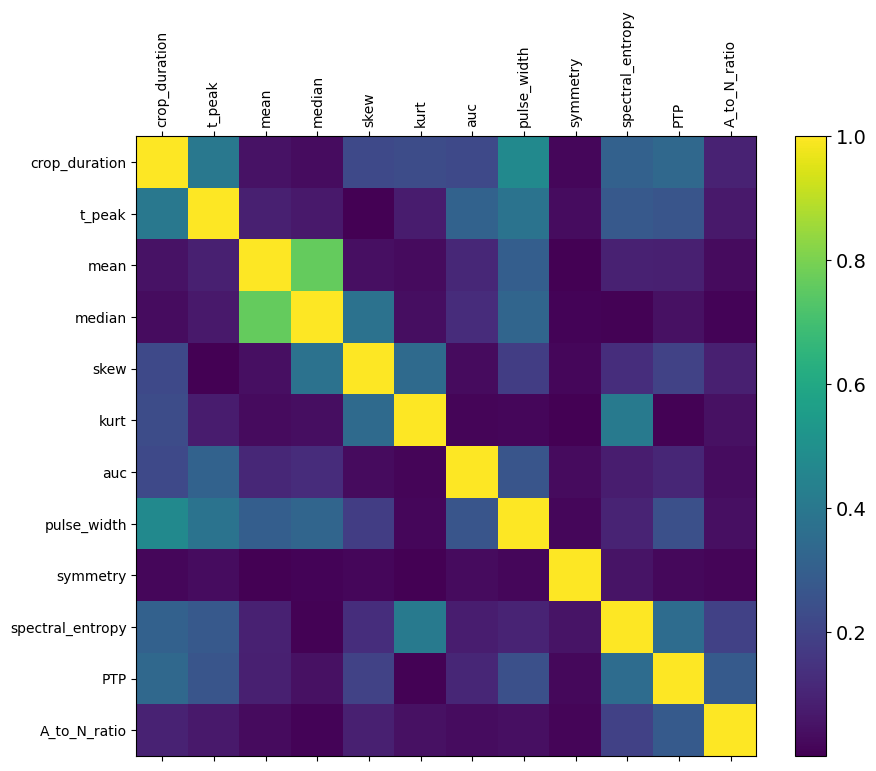

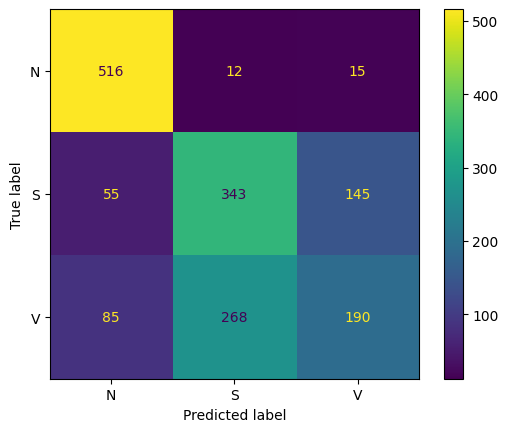

              precision    recall  f1-score   support

           N       0.79      0.95      0.86       543
           S       0.55      0.63      0.59       543
           V       0.54      0.35      0.43       543

    accuracy                           0.64      1629
   macro avg       0.63      0.64      0.62      1629
weighted avg       0.63      0.64      0.62      1629



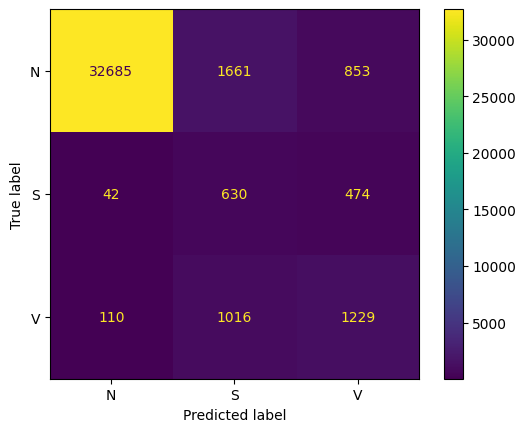

              precision    recall  f1-score   support

           N       1.00      0.93      0.96     35199
           S       0.19      0.55      0.28      1146
           V       0.48      0.52      0.50      2355

    accuracy                           0.89     38700
   macro avg       0.56      0.67      0.58     38700
weighted avg       0.94      0.89      0.91     38700



(RandomForestClassifier(n_estimators=80),
 array(['V', 'S', 'N', ..., 'N', 'V', 'S'], dtype=object),
 array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype=object))

In [94]:
exp_2.main(clf)